## Beam time : 18-FEB-2020 to 23-FEB-2020 at VERITAS
### Step size is set as 0.25 eV, the acquiring time is 15 s, and the slit size is 500 um
### scan range: 880 to 925 eV
### The energy scale is not calibrated 
### smoothListGaussian, window is the range for collecting the average number
### interploate function will return a fun based on the input data and you can find y value by import your x raange   

In [68]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import sys
sys.path.insert(0, '../src1/')
import fit_data_tools
from fit_data_tools import *
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from scipy import interpolate ## will return a function 

In [69]:
def smoothListGaussian(list, degree=3):
    window = degree*2-1
    weight = np.array([1.0]*window)
    weightGauss = []
    for i in range(window):
        i = i-degree+1
        frac = i/float(window)
        gauss = 1/(np.exp((4*(frac))**2))
        weightGauss.append(gauss)
    weight = np.array(weightGauss)*weight
    smoothed = [0.0]*(len(list)-window)
    for i in range(len(smoothed)):
        smoothed[i] = sum(np.array(list[i:i+window])*weight)/sum(weight)
    return smoothed, window
## be careful taht you have to make your own x scale 

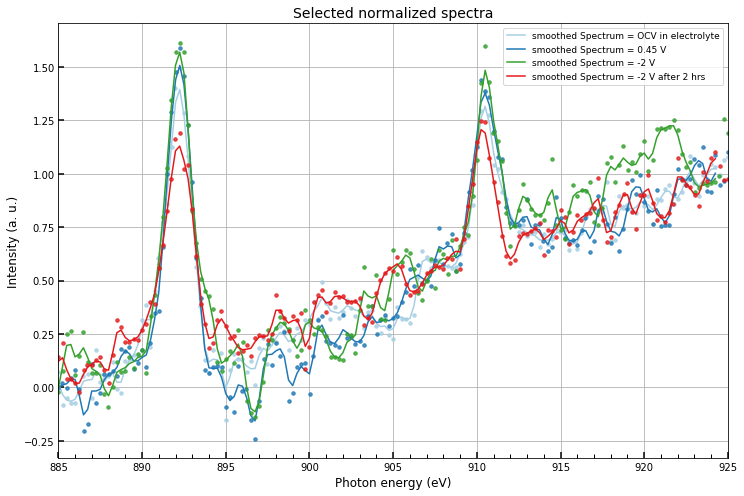

In [85]:
BK_scan = [79] #or 81??
#scan =[78,90,91,93,94,95,96,98,99,100,105,107]
#dataname = ['OCV in water','OCV in electrolyte','-0.084 V','0.11 V','0.45 V','-0.3 V','-0.4 V','-0.65 V','-1.18 V', '-1.4 V','-2 V', '-2 V after 2 hrs']
scan = [90,94,105,107]
dataname = ['OCV in electrolyte','0.45 V','-2 V', '-2 V after 2 hrs']
#scan = [90,90,90]
#dataname = ['OCV in electrolyte','1','2']
Escale_downlimit = 879.98
Escale_uplimit = 925.02
I_0 = 'gold' #gold or mirror
Energy_scale = 'beamline_energy' # 'beamline_energy' 'undulator_energy' 
condition = 'Non_sub_background' # 'Sub_darkI0' 'Sub_darkspec' 'Non_sub_background'
sub_darkI0Cont = 1
sub_darkIfCont = 1

fig, ax = plt.subplots(figsize=[12,8])

TowD_map = []
 
L3pos = [] 
L2pos = []

i =0
while i < len(scan):
    data_path = '/Users/hsin-yiwang/Desktop/Veritas_Data/'
    h5file = h5py.File(data_path+'20200219_1.h5', 'r')
    
    if Energy_scale =='beamline_energy':
        Ev_scale = h5file['/entry%02d/' %scan[i]+'measurement/beamline_energy'].value
        BK_Ev_scale = h5file['/entry%02d/' %BK_scan[0]+'measurement/beamline_energy'].value
    else:
        Ev_scale = h5file['/entry%02d/' %scan[i]+'measurement/b_m4_vertical'].value
        BK_Ev_scale = h5file['/entry%02d/' %BK_scan[0]+'measurement/b_m4_vertical'].value
    
    
    if I_0 == 'gold':
        I0 = h5file['/entry%02d/' %scan[i]+'measurement/aemexp2_ch1'].value
        BK_I0 = h5file['/entry%02d/' %BK_scan[0]+'measurement/aemexp2_ch1'].value
    else:
        I0 = h5file['/entry%02d/' %scan[i]+'measurement/aemexp2_ch2'].value
        BK_I0 = h5file['/entry%02d/' %BK_scan[0]+'measurement/aemexp2_ch2'].value
   
    If = h5file['/entry%02d/' %scan[i]+'measurement/aemexp2_ch3'].value
    BK_If = h5file['/entry%02d/' %BK_scan[0]+'measurement/aemexp2_ch3'].value
    
    ## define the energy scale range
    Esalce_Filter = np.all([Ev_scale>Escale_downlimit, Ev_scale<Escale_uplimit], axis = 0)
    BK_Esalce_Filter = np.all([BK_Ev_scale>Escale_downlimit, BK_Ev_scale<Escale_uplimit], axis = 0)
    Ev_scale = Ev_scale[Esalce_Filter]
    I0 = I0[Esalce_Filter]
    If = If[Esalce_Filter]
    
    BK_Ev_scale = BK_Ev_scale[BK_Esalce_Filter]
    BK_I0 = BK_I0[BK_Esalce_Filter]
    BK_If = BK_If[BK_Esalce_Filter]
    
    Ev_scale[0] = min(BK_Ev_scale)
    Ev_scale[-1] = max(BK_Ev_scale)
    
    f1 = interpolate.interp1d(BK_Ev_scale, BK_I0)
    newBK_I0 = np.array(f1(Ev_scale))
    Sub_DarkI0 = np.array((I0-newBK_I0/float(sub_darkI0Cont)))
    
    f2 = interpolate.interp1d(BK_Ev_scale, BK_If)
    newBK_If = np.array(f2(Ev_scale))
    Sub_DarkIf = np.array((If-newBK_If/float(sub_darkIfCont)))
    
    DarkSpec = []
    for j in np.arange((BK_If.shape[0])):
        darkSpec = BK_If[j]/BK_I0[j]
        DarkSpec.append(darkSpec)
    DarkSpec = np.array(DarkSpec)
    
    
    BK_zero_point = float(np.average(DarkSpec[0:5]))
    DarkSpec = (DarkSpec-BK_zero_point)
    BK_one_point = float(np.average(DarkSpec[-2:-1]))
    DarkSpec = (DarkSpec/BK_one_point)
    
    f3 = interpolate.interp1d(BK_Ev_scale, DarkSpec)
    newDarkSpec = np.array(f3(Ev_scale))
    
    Nor_Intensity = []
    
    if condition == 'Sub_darkI0':
        for j in np.arange((If.shape[0])):
            nor_Intensity  = Sub_DarkIf[j]/Sub_DarkI0[j]
            Nor_Intensity.append(nor_Intensity)
                
    elif condition =='Non_sub_background'or 'Sub_darkspec':
        for j in np.arange((If.shape[0])):
            nor_Intensity  = If[j]/I0[j]
            Nor_Intensity.append(nor_Intensity) 
    
    
    Nor_Intensity = np.array(Nor_Intensity)
    
    ## find L3 and L2 peak position
    Filter1 = np.all([Ev_scale >= 887.5,Ev_scale <= 897.5],axis = 0)
    Filter2 = np.all([Ev_scale >= 905,Ev_scale <= 915],axis = 0)
    I_Sect1 = Nor_Intensity[Filter1]
    E_Sect1 = Ev_scale[Filter1]
    I_Sect2 = Nor_Intensity[Filter2]
    E_Sect2 = Ev_scale[Filter2]
    popt1,xc1,curve1,perr1 = fit(gaussian, E_Sect1, I_Sect1, p0=[max(I_Sect1),E_Sect1[I_Sect1==max(I_Sect1)]-0.5,1.,0.])
    popt2,xc2,curve2,perr2 = fit(gaussian, E_Sect2, I_Sect2, p0=[max(I_Sect2),E_Sect2[I_Sect2==max(I_Sect2)]-0.5,1.,0.])
    L3pos.append(popt1[1])
    L2pos.append(popt2[1])
    
    # for background normaoization 
    zero_point = float(np.average(Nor_Intensity[0:8]))
    Nor_Intensity = (Nor_Intensity-zero_point)
    one_point = float(np.average(Nor_Intensity[-8:-1]))
    Nor_Intensity = (Nor_Intensity/one_point)
    TowD_map.append(Nor_Intensity)
    
    if condition == 'Sub_darkspec': 
        Nor_Intensity  = Nor_Intensity - newDarkSpec
    
    '''
    #poly fit smooth curve
    poly = np.polyfit(Ev_scale,Nor_Intensity,5)
    poly_y = np.poly1d(poly)(Ev_scale)
    plt.plot(Ev_scale,poly_y)
    '''
    # smoothListGaussian, make a new x-axis for smoothed curve
    smoothed, window = smoothListGaussian(Nor_Intensity)
    Ev_smooth =[]
    for j in range(len(smoothed)):
        temp = np.average(Ev_scale[j:j+window])
        Ev_smooth.append(temp) 
    
    color_index = float(i)*2.2/(len(scan)+10)
    color = plt.cm.Paired(color_index)
    plt.plot(Ev_scale,Nor_Intensity,'o',markersize = 3.5, c = color, alpha = 0.8)
    plt.plot(Ev_smooth,smoothed, '-',linewidth = '1.5', c = color, alpha = 1, label = 'smoothed Spectrum = %s' %dataname[i])   
    
    ## plot out raw I0 and If
    #plt.plot(Ev_scale,If, '-o', linewidth ='1',markersize = 3.5, c = color, label = 'Beam on, diode current scan%02d'%scan[i])
    #plt.plot(Ev_scale,I0, '-o', linewidth ='1',markersize = 3.5, c = color, label = 'Beam on, gold current scan%02d, condition: %s'%(scan[i], dataname[i]))
    
    i += 1

## polt out dark scan data
#if condition =='Non_sub_background':
#    plt.plot(BK_Ev_scale, DarkSpec,'-o',linewidth ='1', markersize = 3.5, alpha = 0.7, c = 'r', label = 'Normalized_Dark_Goldcurrent') 
#plt.plot(BK_Ev_scale,BK_I0, '-o',linewidth ='1', markersize = 3.5, c='k', alpha = 0.7, label = 'Beam off, gold current')
#plt.plot(BK_Ev_scale,BK_If,'-o',linewidth ='1', markersize = 3.5, c='k', label = 'Beam off, diode current')

plt.tick_params(direction='in', length=6, width=1.5, axis='both', which='major', labelsize=10)
plt.tick_params(direction='in', length=4, width=1, axis='both', which='minor', labelsize=10)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))
plt.xlim(885,925)
#plt.ylim(-0.26,1.8)
plt.grid(True)
#plt.tight_layout()
plt.legend(frameon=True,loc='best', prop={'size': 9})
plt.title('Selected normalized spectra', size=14)
plt.xlabel('Photon energy (eV)',size=12)
plt.ylabel('Intensity (a. u.)',size=12)
#ax.text(891.8, 1.65, r'$L_3$', fontsize=18)
#ax.text(910.1, 1.5, r'$L_2$', fontsize=18)
#plt.savefig(data_path +'/Selected normalized spectra', dpi=300)
plt.show() 


In [55]:
TowD_map = np.array(TowD_map)
print(TowD_map.shape)

(12, 181)


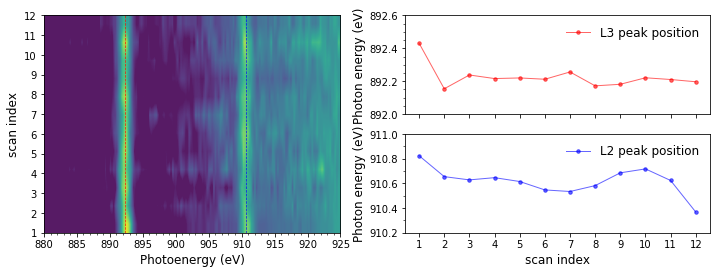

In [58]:
plt.figure(figsize=[12,4])   
ax = plt.subplot(1,2,1)
plt.imshow(TowD_map,vmin=0.2,vmax=1.8,  extent=[880,925,1,12],origin='lower', cmap = 'viridis', interpolation='bilinear',alpha = 0.9)
plt.xlabel('Photoenergy (eV)',size=12)
plt.ylabel('scan index',size=12)
#plt.title('Nonpump_Spectrum 2D map')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="4%", pad=0.1)
#plt.colorbar(cax=cax)
#pos = ax.imshow(TowD_map,vmin=-0.1,vmax=2.7, origin='lower', interpolation='bicubic',alpha = 0.9)
#fig.colorbar(pos, ax=ax)
plt.axvline(x=892.25, ls='--',c='r',lw=0.7,alpha = 0.9)
plt.axvline(x=910.6, ls='--',c='b',lw=0.7,alpha = 0.9)
ax.set_aspect(aspect=3)

 
ax = plt.subplot(2,2,2)
scan_index = list(range(1,13))
plt.plot(scan_index,L3pos, '-o',linewidth ='1', markersize = 3.5 , c='r', alpha = 0.6, label = 'L3 peak position')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.setp(ax.get_xticklabels(), visible=False)
plt.legend(frameon=False,loc='best', prop={'size': 12})
plt.ylim(892,892.6)
#plt.xlabel('scan index',size=12)
plt.ylabel('Photon energy (eV)',size=12)

ax = plt.subplot(2,2,4)
scan_index = list(range(1,13))
plt.plot(scan_index,L2pos,'-o',linewidth ='1', markersize = 3.5,c='b', alpha = 0.6, label = 'L2 peak position')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
plt.legend(frameon=False,loc='best', prop={'size': 12})
plt.ylim(910.2,911)
plt.xlabel('scan index',size=12)
plt.ylabel('Photon energy (eV)',size=12)
plt.savefig(data_path +'/2Dmap with peak position', dpi=300)
plt.show()